In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd 3']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [3]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [5]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.0735e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s]


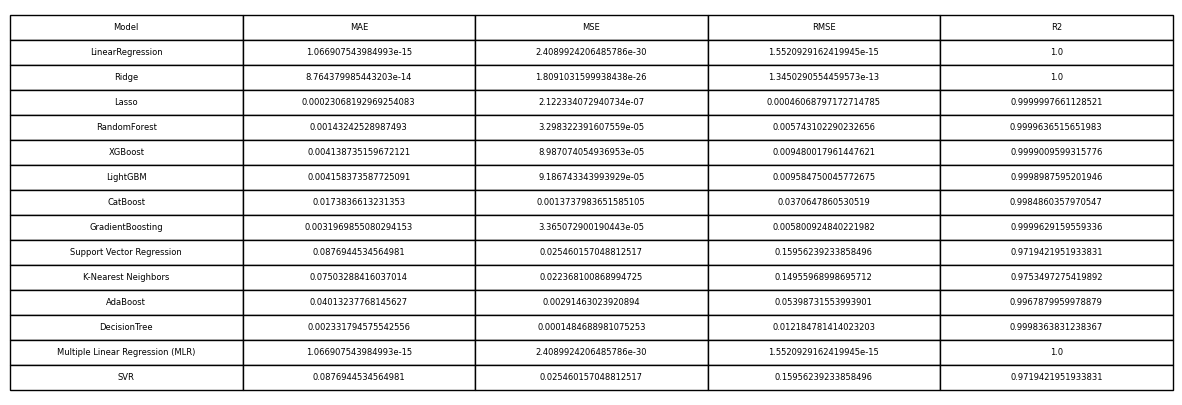

In [6]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

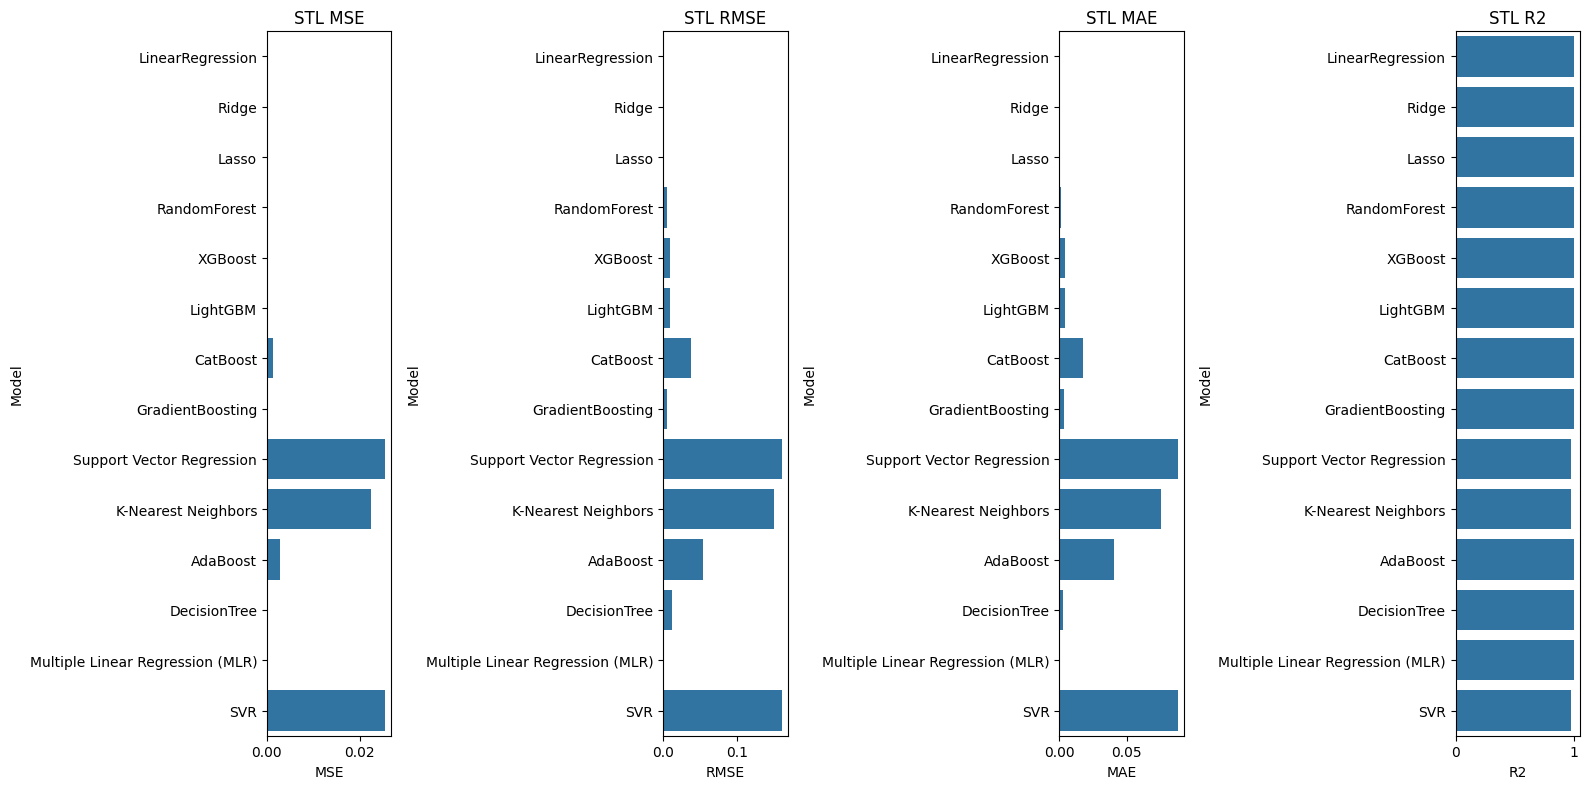

In [7]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

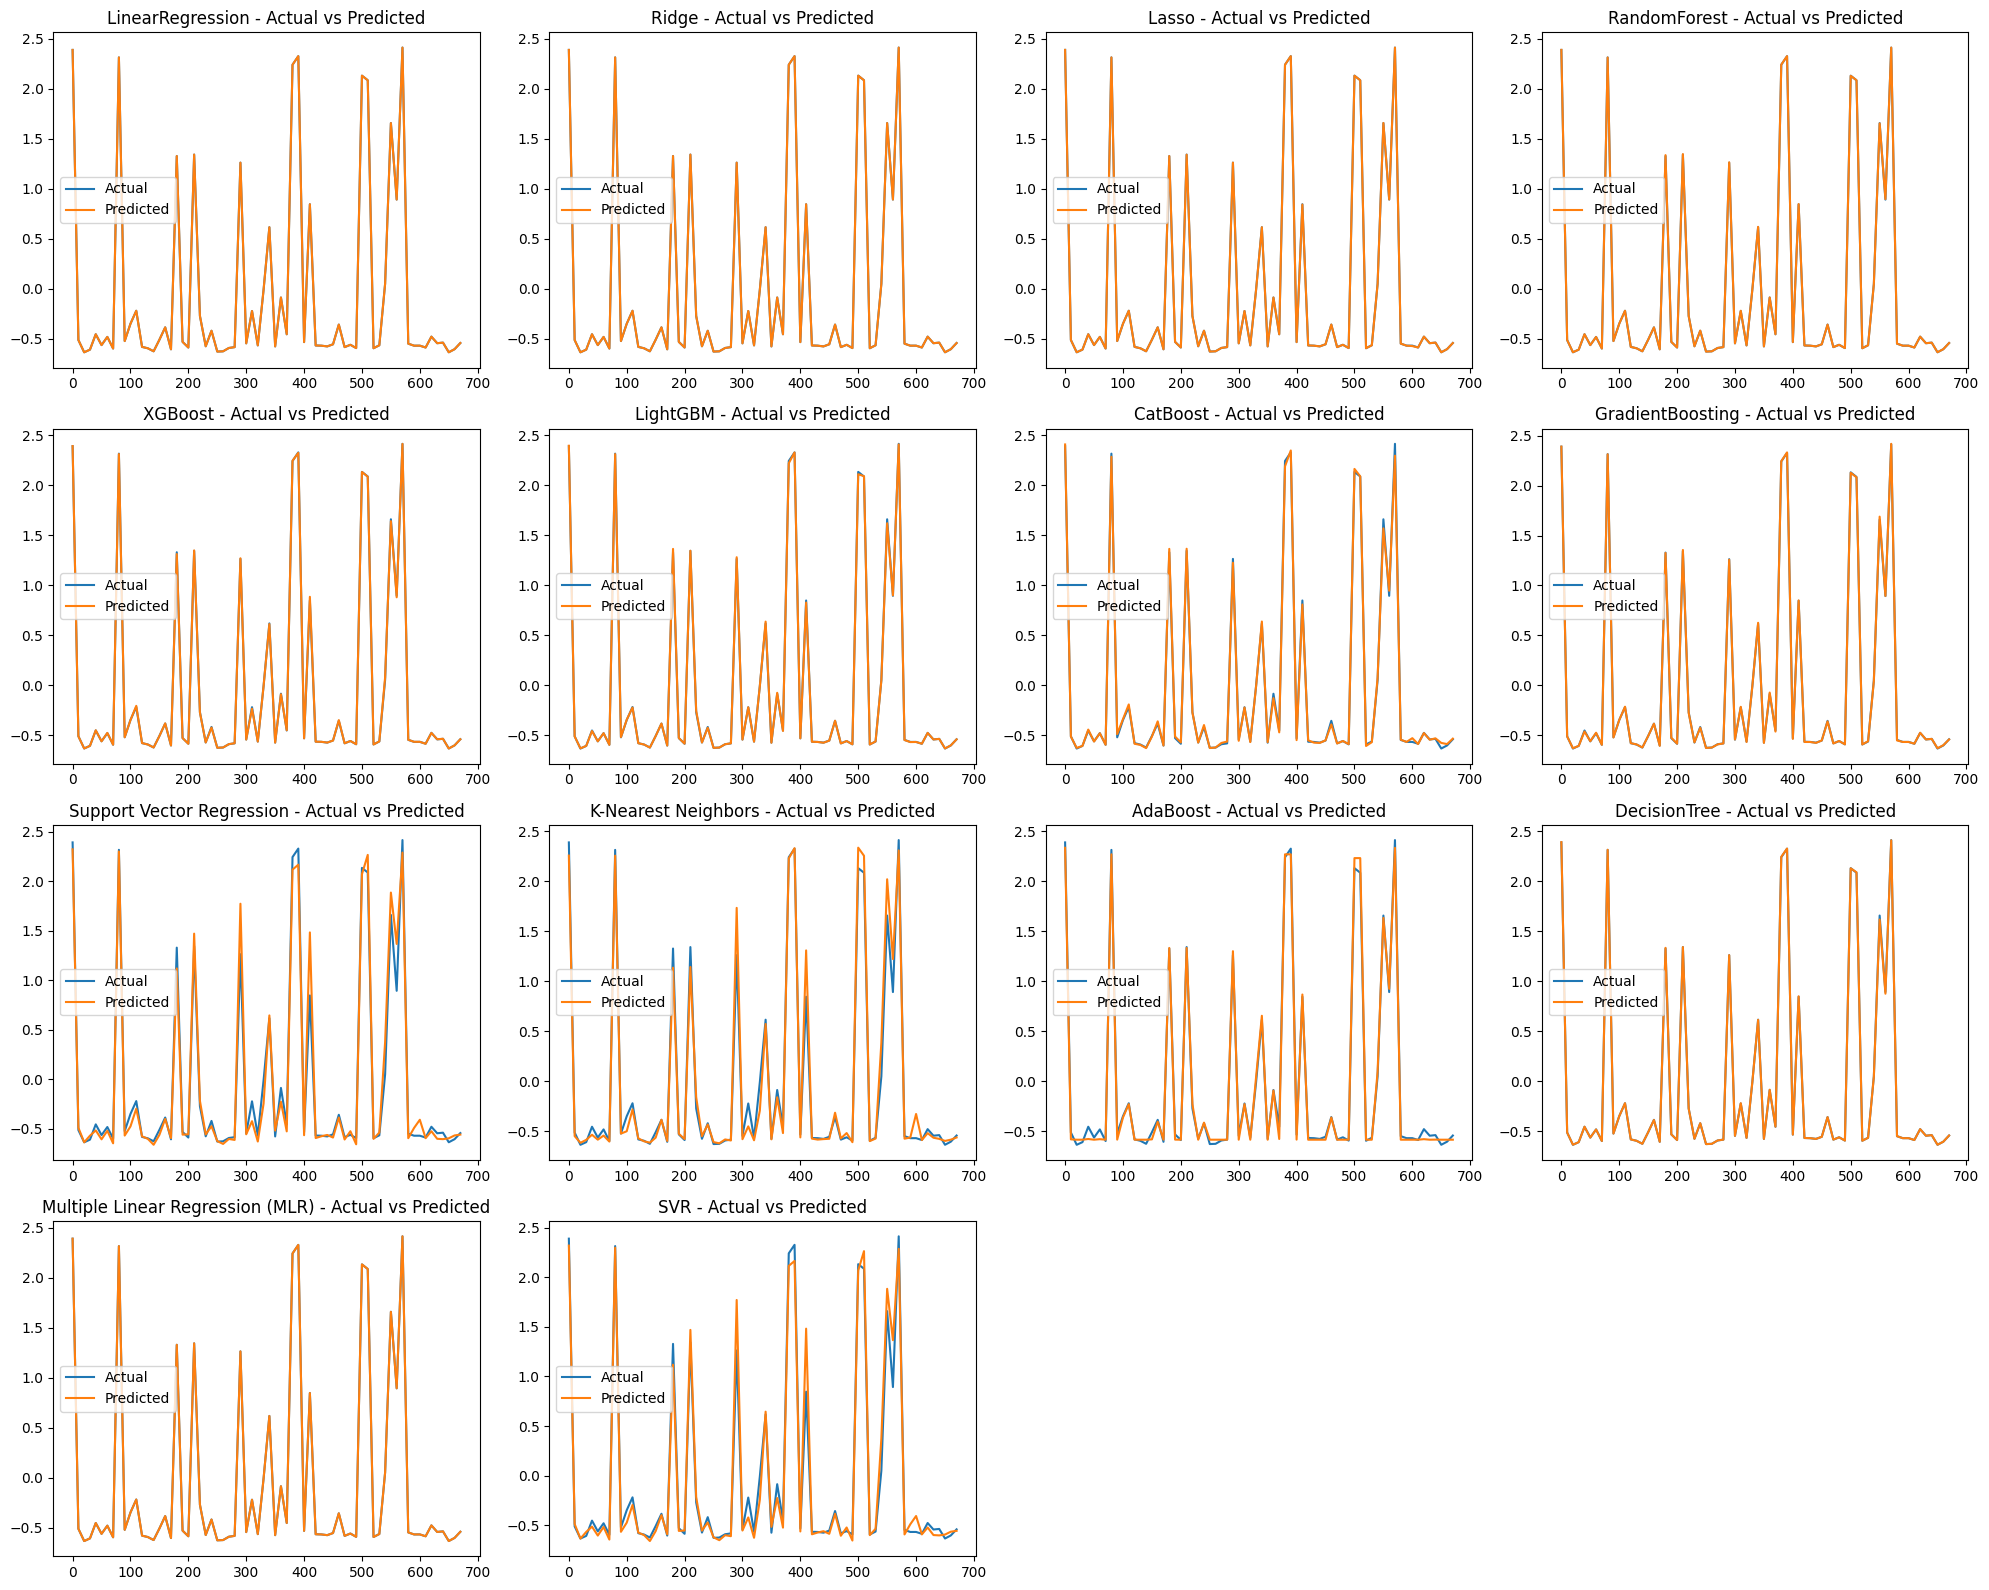

In [8]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [29]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [10]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])


In [12]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)
                
                train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())
                
                print(f"\nModel: {name} | Epoch: {epoch}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
    return history

In [13]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)

                train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
        
        if epoch % 100 == 0:
            print(f"\nModel: {name} | Epoch: {epoch}")
            print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
            print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history


In [14]:
nets = {
    "Net1":   Net1(X.shape[1]),
    "Net2":   Net2(X.shape[1]),
    "Net3":   Net3(X.shape[1]),
    "Net4":   Net4(X.shape[1])
}

nets_tabular = {
    "Net1":    Net1(X.shape[1]),
    "Net2":    Net2(X.shape[1]),
    "Net3":    Net3(X.shape[1]),
    "Net4":    Net4(X.shape[1]),
    "FNN":     FNN(X.shape[1]),
    "DeepFNN": DeepFNN(X.shape[1])
}

In [15]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

 17%|█████████████████▎                                                                                    | 17/100 [00:00<00:02, 32.77it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0018, RMSE: 0.0421, MAE: 0.0310, R2: 0.9983
Test:  MSE: 0.0022, RMSE: 0.0466, MAE: 0.0345, R2: 0.9976


 25%|█████████████████████████▌                                                                            | 25/100 [00:00<00:02, 33.98it/s]


Model: Net1 | Epoch: 20
Train: MSE: 0.0005, RMSE: 0.0233, MAE: 0.0171, R2: 0.9995
Test:  MSE: 0.0008, RMSE: 0.0276, MAE: 0.0200, R2: 0.9992


 37%|█████████████████████████████████████▋                                                                | 37/100 [00:01<00:01, 34.74it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0003, RMSE: 0.0179, MAE: 0.0133, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0220, MAE: 0.0159, R2: 0.9995


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 35.03it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0002, RMSE: 0.0149, MAE: 0.0110, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0194, MAE: 0.0136, R2: 0.9996


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [00:01<00:01, 34.77it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0139, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0187, MAE: 0.0133, R2: 0.9996


 65%|██████████████████████████████████████████████████████████████████▎                                   | 65/100 [00:01<00:01, 34.94it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0123, MAE: 0.0092, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0165, MAE: 0.0116, R2: 0.9997


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:02<00:00, 34.12it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0112, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0154, MAE: 0.0108, R2: 0.9997


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:02<00:00, 31.40it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0100, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0145, MAE: 0.0101, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:02<00:00, 32.44it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0138, MAE: 0.0095, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.71it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0090, R2: 0.9998


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 21.30it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0005, RMSE: 0.0213, MAE: 0.0161, R2: 0.9996
Test:  MSE: 0.0008, RMSE: 0.0280, MAE: 0.0193, R2: 0.9991


 24%|████████████████████████▍                                                                             | 24/100 [00:01<00:03, 21.27it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0003, RMSE: 0.0174, MAE: 0.0130, R2: 0.9997
Test:  MSE: 0.0006, RMSE: 0.0235, MAE: 0.0161, R2: 0.9994


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:03, 21.25it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0116, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0004, RMSE: 0.0189, MAE: 0.0120, R2: 0.9996


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:01<00:02, 21.20it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0108, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0176, MAE: 0.0118, R2: 0.9997


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:02, 20.90it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0160, MAE: 0.0104, R2: 0.9997


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 20.57it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0154, MAE: 0.0100, R2: 0.9997


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:03<00:01, 20.48it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0002, RMSE: 0.0146, MAE: 0.0109, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0188, MAE: 0.0127, R2: 0.9996


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 21.12it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0063, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0002, RMSE: 0.0139, MAE: 0.0081, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:04<00:00, 21.19it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0058, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0143, MAE: 0.0086, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.06it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0102, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0156, MAE: 0.0093, R2: 0.9997


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 16.14it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0003, RMSE: 0.0177, MAE: 0.0128, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0218, MAE: 0.0147, R2: 0.9995


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:04, 16.26it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0157, MAE: 0.0108, R2: 0.9997


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:04, 16.19it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0060, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0083, R2: 0.9998


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 16.51it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0000, RMSE: 0.0065, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0077, R2: 0.9998


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:02, 16.75it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0003, RMSE: 0.0186, MAE: 0.0138, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0192, MAE: 0.0140, R2: 0.9996


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:02, 16.69it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0132, MAE: 0.0094, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 16.77it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0021, RMSE: 0.0463, MAE: 0.0301, R2: 0.9979
Test:  MSE: 0.0020, RMSE: 0.0452, MAE: 0.0294, R2: 0.9977


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 16.50it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0069, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0065, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:05<00:00, 16.74it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0055, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0069, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.44it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0012, RMSE: 0.0350, MAE: 0.0198, R2: 0.9988
Test:  MSE: 0.0011, RMSE: 0.0333, MAE: 0.0192, R2: 0.9988


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  6.89it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0106, RMSE: 0.1031, MAE: 0.0734, R2: 0.9896
Test:  MSE: 0.0100, RMSE: 0.0999, MAE: 0.0723, R2: 0.9890


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:11,  7.08it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0079, RMSE: 0.0890, MAE: 0.0583, R2: 0.9923
Test:  MSE: 0.0074, RMSE: 0.0863, MAE: 0.0581, R2: 0.9918


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:09,  7.46it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0115, RMSE: 0.1072, MAE: 0.0685, R2: 0.9888
Test:  MSE: 0.0101, RMSE: 0.1007, MAE: 0.0645, R2: 0.9888


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:05<00:07,  7.41it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0051, RMSE: 0.0713, MAE: 0.0543, R2: 0.9950
Test:  MSE: 0.0047, RMSE: 0.0686, MAE: 0.0535, R2: 0.9948


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:07<00:06,  7.50it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0073, RMSE: 0.0854, MAE: 0.0561, R2: 0.9929
Test:  MSE: 0.0065, RMSE: 0.0809, MAE: 0.0547, R2: 0.9928


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:08<00:06,  6.48it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0114, RMSE: 0.1067, MAE: 0.0597, R2: 0.9889
Test:  MSE: 0.0093, RMSE: 0.0966, MAE: 0.0550, R2: 0.9897


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:09<00:03,  7.46it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0073, RMSE: 0.0857, MAE: 0.0630, R2: 0.9928
Test:  MSE: 0.0066, RMSE: 0.0814, MAE: 0.0611, R2: 0.9927


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:11<00:02,  7.54it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0190, RMSE: 0.1380, MAE: 0.0844, R2: 0.9814
Test:  MSE: 0.0159, RMSE: 0.1262, MAE: 0.0780, R2: 0.9824


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:12<00:01,  7.35it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0068, RMSE: 0.0824, MAE: 0.0579, R2: 0.9934
Test:  MSE: 0.0062, RMSE: 0.0785, MAE: 0.0566, R2: 0.9932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.25it/s]


Model: Net4 | Epoch: 100
Train: MSE: 0.0099, RMSE: 0.0994, MAE: 0.0727, R2: 0.9904
Test:  MSE: 0.0090, RMSE: 0.0947, MAE: 0.0710, R2: 0.9901


In [16]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

 17%|█████████████████▎                                                                                    | 17/100 [00:01<00:03, 25.65it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0158, RMSE: 0.1259, MAE: 0.0865, R2: 0.9845
Test:  MSE: 0.0168, RMSE: 0.1295, MAE: 0.0884, R2: 0.9815

Model: Net1 | Epoch: 20
Train: MSE: 0.0039, RMSE: 0.0627, MAE: 0.0465, R2: 0.9962
Test:  MSE: 0.0045, RMSE: 0.0667, MAE: 0.0488, R2: 0.9951


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:01, 36.04it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0019, RMSE: 0.0436, MAE: 0.0317, R2: 0.9981
Test:  MSE: 0.0023, RMSE: 0.0475, MAE: 0.0336, R2: 0.9975


 48%|████████████████████████████████████████████████▉                                                     | 48/100 [00:01<00:01, 41.01it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0013, RMSE: 0.0361, MAE: 0.0259, R2: 0.9987
Test:  MSE: 0.0016, RMSE: 0.0405, MAE: 0.0281, R2: 0.9982


 58%|███████████████████████████████████████████████████████████▏                                          | 58/100 [00:02<00:01, 40.51it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0010, RMSE: 0.0313, MAE: 0.0224, R2: 0.9990
Test:  MSE: 0.0013, RMSE: 0.0360, MAE: 0.0246, R2: 0.9986


 68%|█████████████████████████████████████████████████████████████████████▎                                | 68/100 [00:02<00:00, 40.96it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0008, RMSE: 0.0278, MAE: 0.0199, R2: 0.9992
Test:  MSE: 0.0011, RMSE: 0.0328, MAE: 0.0222, R2: 0.9988


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [00:02<00:00, 40.64it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0006, RMSE: 0.0252, MAE: 0.0180, R2: 0.9994
Test:  MSE: 0.0009, RMSE: 0.0302, MAE: 0.0202, R2: 0.9990


 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 88/100 [00:02<00:00, 42.03it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0005, RMSE: 0.0232, MAE: 0.0166, R2: 0.9995
Test:  MSE: 0.0008, RMSE: 0.0282, MAE: 0.0187, R2: 0.9991


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:02<00:00, 42.65it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0005, RMSE: 0.0217, MAE: 0.0156, R2: 0.9995
Test:  MSE: 0.0007, RMSE: 0.0269, MAE: 0.0177, R2: 0.9992


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.29it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0004, RMSE: 0.0204, MAE: 0.0146, R2: 0.9996
Test:  MSE: 0.0007, RMSE: 0.0257, MAE: 0.0168, R2: 0.9993


 17%|█████████████████▎                                                                                    | 17/100 [00:00<00:02, 36.44it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0016, RMSE: 0.0401, MAE: 0.0293, R2: 0.9984
Test:  MSE: 0.0021, RMSE: 0.0458, MAE: 0.0307, R2: 0.9977


 25%|█████████████████████████▌                                                                            | 25/100 [00:00<00:02, 36.09it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0007, RMSE: 0.0255, MAE: 0.0186, R2: 0.9994
Test:  MSE: 0.0010, RMSE: 0.0317, MAE: 0.0208, R2: 0.9989


 37%|█████████████████████████████████████▋                                                                | 37/100 [00:01<00:01, 35.41it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0004, RMSE: 0.0195, MAE: 0.0140, R2: 0.9996
Test:  MSE: 0.0007, RMSE: 0.0260, MAE: 0.0166, R2: 0.9993


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 35.75it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0003, RMSE: 0.0164, MAE: 0.0117, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0231, MAE: 0.0146, R2: 0.9994


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [00:01<00:01, 35.86it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0143, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0005, RMSE: 0.0214, MAE: 0.0133, R2: 0.9995


 65%|██████████████████████████████████████████████████████████████████▎                                   | 65/100 [00:01<00:00, 35.86it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0124, MAE: 0.0089, R2: 0.9999
Test:  MSE: 0.0004, RMSE: 0.0199, MAE: 0.0120, R2: 0.9996


 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 77/100 [00:02<00:00, 36.37it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0113, MAE: 0.0083, R2: 0.9999
Test:  MSE: 0.0004, RMSE: 0.0190, MAE: 0.0113, R2: 0.9996


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:02<00:00, 36.34it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0182, MAE: 0.0107, R2: 0.9996


 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 89/100 [00:02<00:00, 36.24it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0174, MAE: 0.0101, R2: 0.9997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.14it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0091, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0171, MAE: 0.0099, R2: 0.9997


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 30.23it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0008, RMSE: 0.0287, MAE: 0.0209, R2: 0.9992
Test:  MSE: 0.0010, RMSE: 0.0320, MAE: 0.0236, R2: 0.9989


 25%|█████████████████████████▌                                                                            | 25/100 [00:00<00:02, 28.47it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0004, RMSE: 0.0188, MAE: 0.0139, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0215, MAE: 0.0153, R2: 0.9995


 34%|██████████████████████████████████▋                                                                   | 34/100 [00:01<00:02, 28.95it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0002, RMSE: 0.0139, MAE: 0.0101, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0167, MAE: 0.0118, R2: 0.9997


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:02, 26.24it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0113, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0144, MAE: 0.0099, R2: 0.9998


 55%|████████████████████████████████████████████████████████                                              | 55/100 [00:01<00:01, 26.12it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0088, R2: 0.9998


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:02<00:01, 26.80it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0082, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0119, MAE: 0.0082, R2: 0.9998


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 28.42it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0075, MAE: 0.0057, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0080, R2: 0.9999


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:03<00:00, 30.09it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0063, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0102, MAE: 0.0069, R2: 0.9999


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:03<00:00, 29.87it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0060, MAE: 0.0044, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0100, MAE: 0.0068, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.34it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0000, RMSE: 0.0054, MAE: 0.0040, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0096, MAE: 0.0064, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:06, 13.96it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0040, RMSE: 0.0629, MAE: 0.0524, R2: 0.9961
Test:  MSE: 0.0042, RMSE: 0.0647, MAE: 0.0537, R2: 0.9954


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:05, 14.11it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0033, RMSE: 0.0575, MAE: 0.0420, R2: 0.9968
Test:  MSE: 0.0033, RMSE: 0.0575, MAE: 0.0429, R2: 0.9964


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:04, 14.12it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0042, RMSE: 0.0647, MAE: 0.0479, R2: 0.9959
Test:  MSE: 0.0039, RMSE: 0.0622, MAE: 0.0474, R2: 0.9957


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:04, 13.91it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0030, RMSE: 0.0551, MAE: 0.0452, R2: 0.9970
Test:  MSE: 0.0035, RMSE: 0.0595, MAE: 0.0476, R2: 0.9961


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:03, 13.97it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0089, RMSE: 0.0943, MAE: 0.0565, R2: 0.9913
Test:  MSE: 0.0078, RMSE: 0.0881, MAE: 0.0538, R2: 0.9914


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 13.89it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0066, RMSE: 0.0814, MAE: 0.0722, R2: 0.9935
Test:  MSE: 0.0070, RMSE: 0.0835, MAE: 0.0726, R2: 0.9923


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:05<00:02, 13.79it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0037, RMSE: 0.0611, MAE: 0.0420, R2: 0.9964
Test:  MSE: 0.0037, RMSE: 0.0612, MAE: 0.0431, R2: 0.9959


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 13.73it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0034, RMSE: 0.0585, MAE: 0.0500, R2: 0.9967
Test:  MSE: 0.0040, RMSE: 0.0630, MAE: 0.0521, R2: 0.9956


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:06<00:00, 12.41it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0056, RMSE: 0.0747, MAE: 0.0532, R2: 0.9945
Test:  MSE: 0.0053, RMSE: 0.0726, MAE: 0.0533, R2: 0.9942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.68it/s]



Model: Net4 | Epoch: 100
Train: MSE: 0.0087, RMSE: 0.0930, MAE: 0.0632, R2: 0.9915
Test:  MSE: 0.0078, RMSE: 0.0881, MAE: 0.0611, R2: 0.9914


 16%|████████████████▎                                                                                     | 16/100 [00:00<00:02, 31.08it/s]


Model: FNN | Epoch: 10
Train: MSE: 0.0111, RMSE: 0.1056, MAE: 0.0765, R2: 0.9891
Test:  MSE: 0.0116, RMSE: 0.1077, MAE: 0.0787, R2: 0.9872


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 31.27it/s]


Model: FNN | Epoch: 20
Train: MSE: 0.0083, RMSE: 0.0913, MAE: 0.0660, R2: 0.9919
Test:  MSE: 0.0083, RMSE: 0.0911, MAE: 0.0676, R2: 0.9909


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:01<00:02, 31.37it/s]


Model: FNN | Epoch: 30
Train: MSE: 0.0119, RMSE: 0.1089, MAE: 0.0706, R2: 0.9884
Test:  MSE: 0.0113, RMSE: 0.1061, MAE: 0.0699, R2: 0.9876


 44%|████████████████████████████████████████████▉                                                         | 44/100 [00:01<00:01, 31.55it/s]


Model: FNN | Epoch: 40
Train: MSE: 0.0058, RMSE: 0.0764, MAE: 0.0537, R2: 0.9943
Test:  MSE: 0.0059, RMSE: 0.0769, MAE: 0.0546, R2: 0.9935


 56%|█████████████████████████████████████████████████████████                                             | 56/100 [00:01<00:01, 31.36it/s]


Model: FNN | Epoch: 50
Train: MSE: 0.0054, RMSE: 0.0738, MAE: 0.0528, R2: 0.9947
Test:  MSE: 0.0055, RMSE: 0.0744, MAE: 0.0541, R2: 0.9939


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:02<00:01, 31.19it/s]


Model: FNN | Epoch: 60
Train: MSE: 0.0048, RMSE: 0.0693, MAE: 0.0488, R2: 0.9953
Test:  MSE: 0.0049, RMSE: 0.0700, MAE: 0.0504, R2: 0.9946


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:02<00:00, 31.13it/s]


Model: FNN | Epoch: 70
Train: MSE: 0.0033, RMSE: 0.0572, MAE: 0.0411, R2: 0.9968
Test:  MSE: 0.0037, RMSE: 0.0611, MAE: 0.0444, R2: 0.9959


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:02<00:00, 30.12it/s]


Model: FNN | Epoch: 80
Train: MSE: 0.0035, RMSE: 0.0589, MAE: 0.0428, R2: 0.9966
Test:  MSE: 0.0037, RMSE: 0.0611, MAE: 0.0449, R2: 0.9959


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:03<00:00, 30.63it/s]


Model: FNN | Epoch: 90
Train: MSE: 0.0057, RMSE: 0.0756, MAE: 0.0510, R2: 0.9944
Test:  MSE: 0.0055, RMSE: 0.0740, MAE: 0.0512, R2: 0.9940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.87it/s]



Model: FNN | Epoch: 100
Train: MSE: 0.0044, RMSE: 0.0660, MAE: 0.0485, R2: 0.9957
Test:  MSE: 0.0046, RMSE: 0.0677, MAE: 0.0506, R2: 0.9950


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 28.96it/s]


Model: DeepFNN | Epoch: 10
Train: MSE: 0.0154, RMSE: 0.1243, MAE: 0.0937, R2: 0.9849
Test:  MSE: 0.0149, RMSE: 0.1220, MAE: 0.0911, R2: 0.9836


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 28.65it/s]


Model: DeepFNN | Epoch: 20
Train: MSE: 0.0131, RMSE: 0.1142, MAE: 0.0877, R2: 0.9873
Test:  MSE: 0.0125, RMSE: 0.1117, MAE: 0.0851, R2: 0.9863


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 28.88it/s]


Model: DeepFNN | Epoch: 30
Train: MSE: 0.0065, RMSE: 0.0809, MAE: 0.0616, R2: 0.9936
Test:  MSE: 0.0065, RMSE: 0.0806, MAE: 0.0611, R2: 0.9928


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 28.44it/s]


Model: DeepFNN | Epoch: 40
Train: MSE: 0.0054, RMSE: 0.0734, MAE: 0.0582, R2: 0.9947
Test:  MSE: 0.0055, RMSE: 0.0739, MAE: 0.0583, R2: 0.9940


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 28.29it/s]


Model: DeepFNN | Epoch: 50
Train: MSE: 0.0033, RMSE: 0.0577, MAE: 0.0437, R2: 0.9967
Test:  MSE: 0.0035, RMSE: 0.0591, MAE: 0.0460, R2: 0.9962


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 28.41it/s]


Model: DeepFNN | Epoch: 60
Train: MSE: 0.0052, RMSE: 0.0722, MAE: 0.0514, R2: 0.9949
Test:  MSE: 0.0049, RMSE: 0.0698, MAE: 0.0510, R2: 0.9946


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:00, 27.65it/s]


Model: DeepFNN | Epoch: 70
Train: MSE: 0.0092, RMSE: 0.0958, MAE: 0.0676, R2: 0.9910
Test:  MSE: 0.0085, RMSE: 0.0921, MAE: 0.0670, R2: 0.9906


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 24.07it/s]


Model: DeepFNN | Epoch: 80
Train: MSE: 0.0077, RMSE: 0.0878, MAE: 0.0576, R2: 0.9925
Test:  MSE: 0.0070, RMSE: 0.0835, MAE: 0.0565, R2: 0.9923


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 26.89it/s]


Model: DeepFNN | Epoch: 90
Train: MSE: 0.0037, RMSE: 0.0609, MAE: 0.0442, R2: 0.9964
Test:  MSE: 0.0036, RMSE: 0.0600, MAE: 0.0446, R2: 0.9960


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.46it/s]


Model: DeepFNN | Epoch: 100
Train: MSE: 0.0087, RMSE: 0.0934, MAE: 0.0652, R2: 0.9915
Test:  MSE: 0.0081, RMSE: 0.0899, MAE: 0.0650, R2: 0.9911


In [17]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [18]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1    100   0.000076  0.000178    0.008713   0.013329   0.006522   
1  Net2     80   0.000039  0.000194    0.006276   0.013946   0.004722   
2  Net3     80   0.000047  0.000111    0.006865   0.010525   0.005018   
3  Net4     40   0.005077  0.004703    0.071255   0.068580   0.054301   

   Test MAE  Train R2   Test R2  
0  0.008981  0.999926  0.999804  
1  0.008110  0.999962  0.999786  
2  0.006502  0.999954  0.999878  
3  0.053522  0.995042  0.994817

In [19]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     50   0.003333  0.003493    0.057732   0.059102   0.043718   
1      FNN     80   0.003468  0.003729    0.058890   0.061063   0.042755   
2     Net1    100   0.000417  0.000660    0.020412   0.025696   0.014626   
3     Net2    100   0.000082  0.000292    0.009068   0.017101   0.006546   
4     Net3    100   0.000029  0.000092    0.005424   0.009567   0.004011   
5     Net4     20   0.003307  0.003305    0.057510   0.057489   0.042021   

   Test MAE  Train R2   Test R2  
0  0.045996  0.996745  0.996151  
1  0.044932  0.996614  0.995891  
2  0.016809  0.999593  0.999272  
3  0.009908  0.999920  0.999678  
4  0.006407  0.999971  0.999899  
5  0.042934  0.996771  0.996358

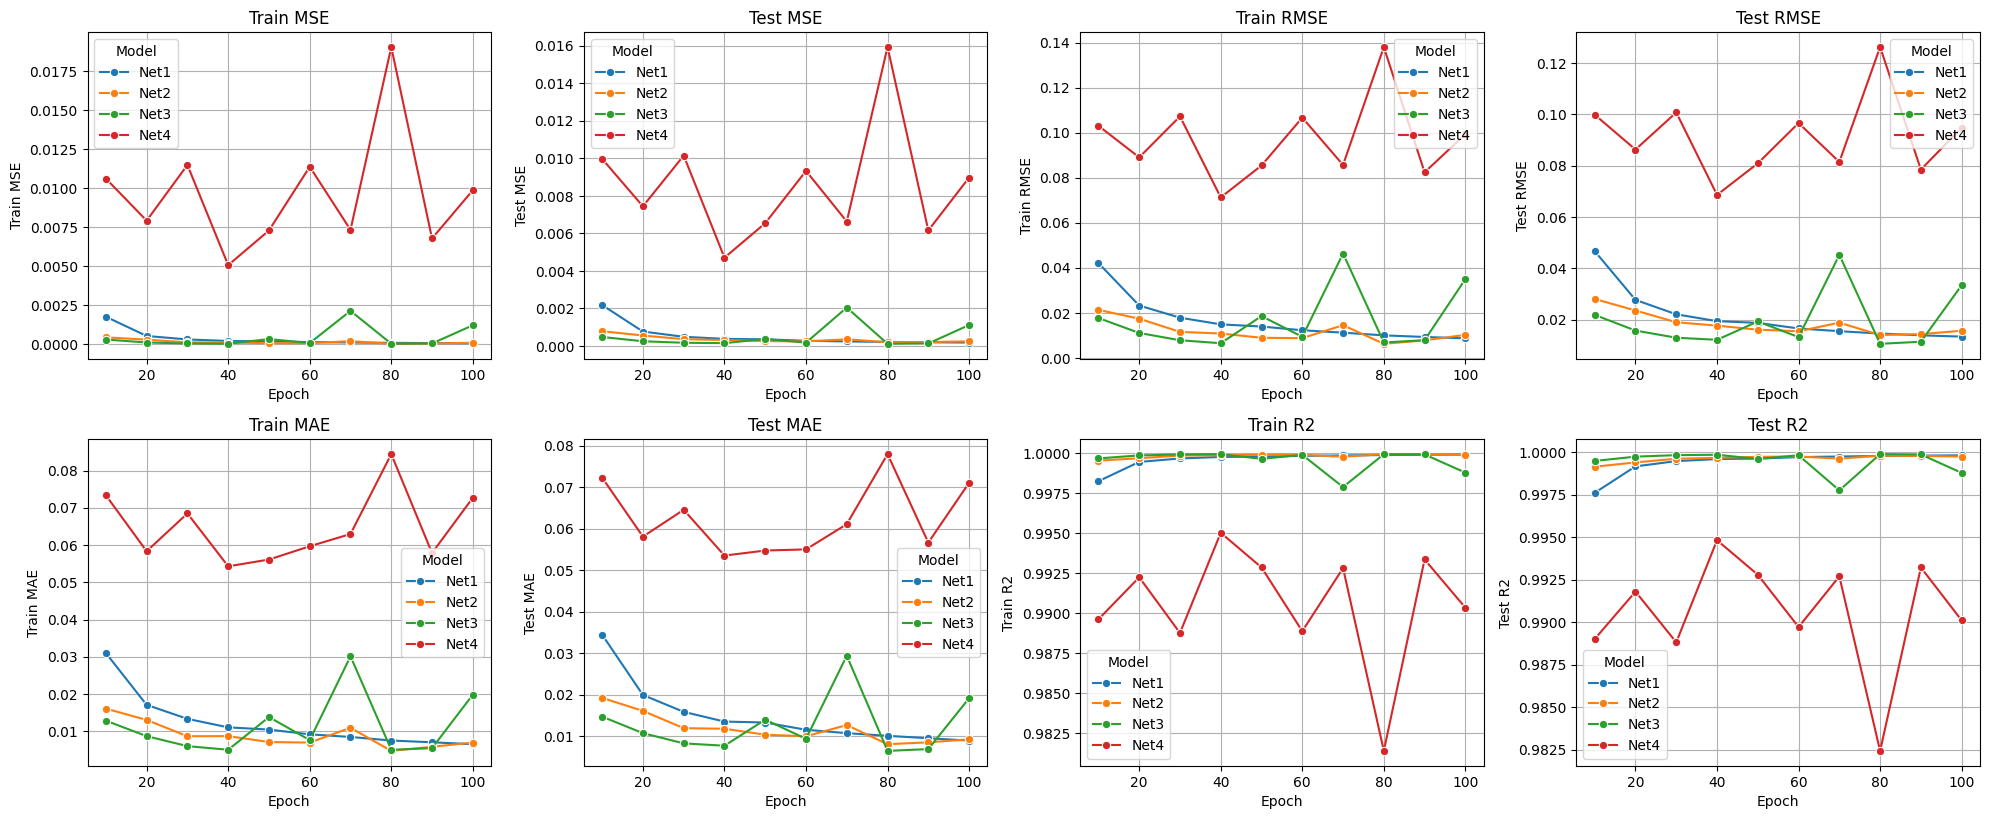

In [42]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

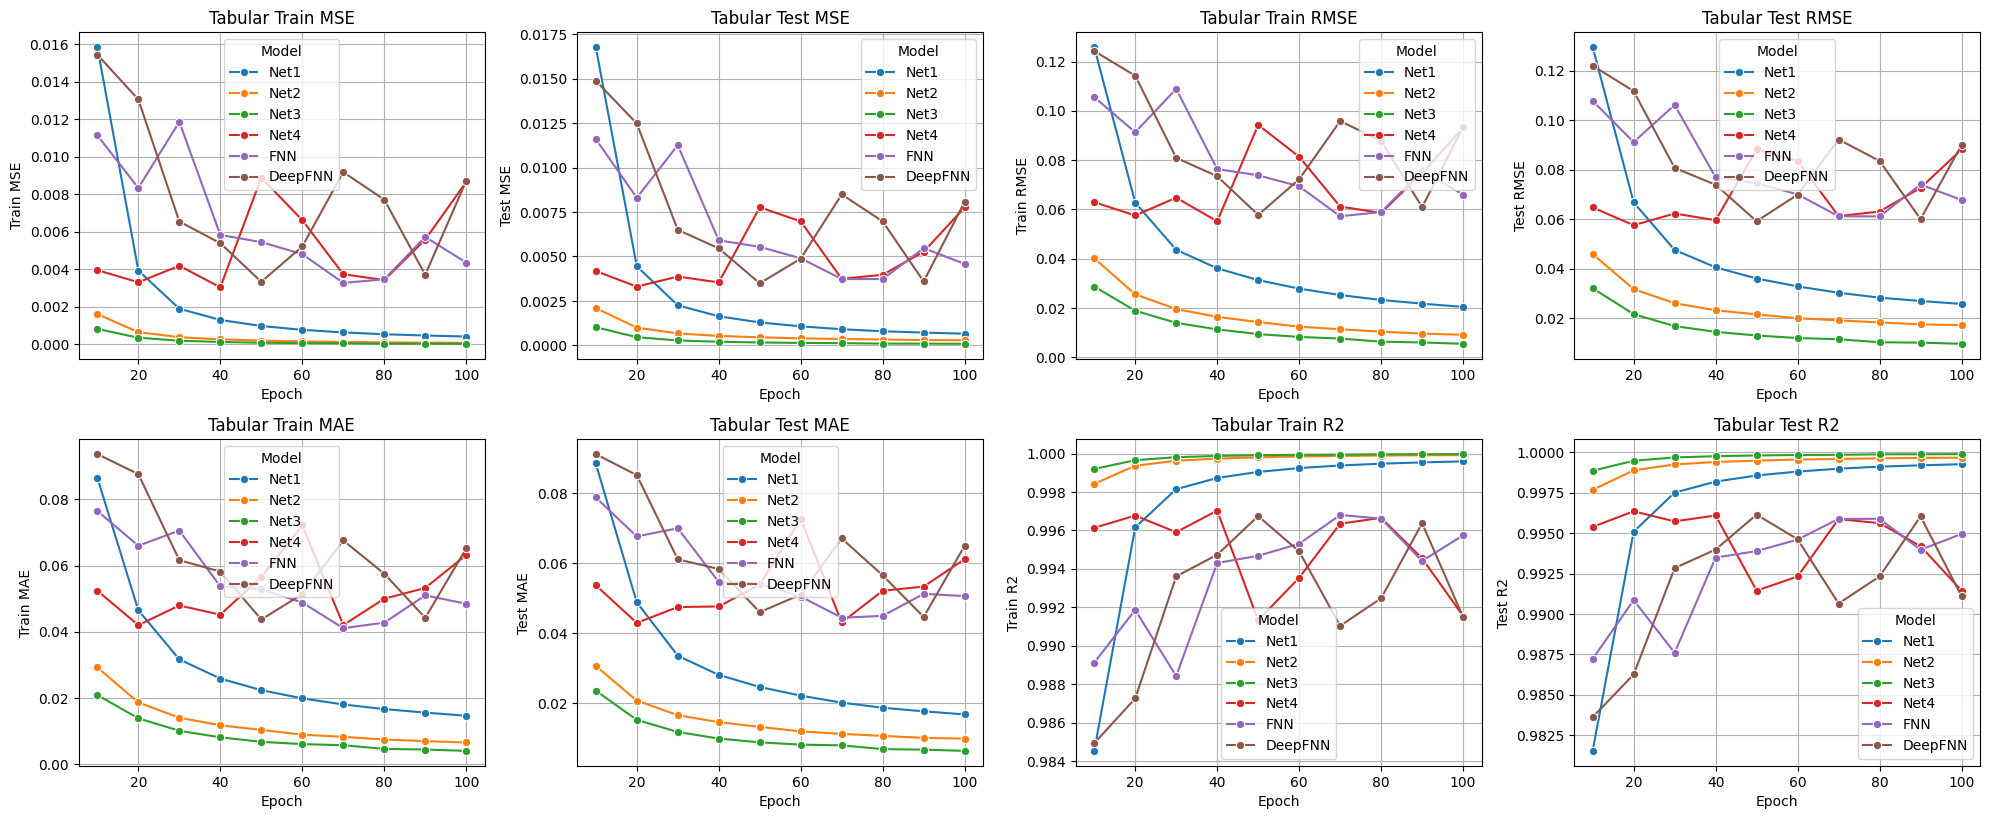

In [43]:
train_figures_tabular = {}

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [23]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [24]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]



Model: TCN | Epoch: 100
Train: MSE: 0.0069, RMSE: 0.0830, MAE: 0.0489, R2: 0.9931
Test:  MSE: 0.0393, RMSE: 0.1982, MAE: 0.1539, R2: 0.9839


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]



Model: CNN1D | Epoch: 100
Train: MSE: 0.0144, RMSE: 0.1199, MAE: 0.0726, R2: 0.9856
Test:  MSE: 0.0697, RMSE: 0.2641, MAE: 0.1811, R2: 0.9715


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]



Model: GRUNet | Epoch: 100
Train: MSE: 0.0065, RMSE: 0.0807, MAE: 0.0491, R2: 0.9935
Test:  MSE: 0.2686, RMSE: 0.5183, MAE: 0.3199, R2: 0.8901


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.40it/s]



Model: RNNNet | Epoch: 100
Train: MSE: 0.0055, RMSE: 0.0744, MAE: 0.0484, R2: 0.9945
Test:  MSE: 0.0914, RMSE: 0.3023, MAE: 0.2357, R2: 0.9626


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]



Model: CNNLSTM | Epoch: 100
Train: MSE: 0.0155, RMSE: 0.1245, MAE: 0.0729, R2: 0.9845
Test:  MSE: 0.0482, RMSE: 0.2196, MAE: 0.1741, R2: 0.9803


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]



Model: BiLSTMNet | Epoch: 100
Train: MSE: 0.0091, RMSE: 0.0956, MAE: 0.0548, R2: 0.9909
Test:  MSE: 0.2710, RMSE: 0.5206, MAE: 0.3359, R2: 0.8891


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]



Model: DeepLSTMNet | Epoch: 100
Train: MSE: 0.0121, RMSE: 0.1100, MAE: 0.0639, R2: 0.9879
Test:  MSE: 0.2265, RMSE: 0.4760, MAE: 0.2690, R2: 0.9073


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]



Model: CNNBiLSTM | Epoch: 100
Train: MSE: 0.0105, RMSE: 0.1027, MAE: 0.0567, R2: 0.9895
Test:  MSE: 0.0511, RMSE: 0.2261, MAE: 0.1850, R2: 0.9791


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]



Model: GRUCNN | Epoch: 100
Train: MSE: 0.0122, RMSE: 0.1105, MAE: 0.0661, R2: 0.9878
Test:  MSE: 0.2120, RMSE: 0.4604, MAE: 0.3049, R2: 0.9133


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.81s/it]



Model: TCNLSTM | Epoch: 100
Train: MSE: 0.0049, RMSE: 0.0703, MAE: 0.0390, R2: 0.9951
Test:  MSE: 0.0367, RMSE: 0.1916, MAE: 0.1524, R2: 0.9850


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


Model: Seq2SeqLSTM | Epoch: 100
Train: MSE: 0.0074, RMSE: 0.0862, MAE: 0.0541, R2: 0.9926
Test:  MSE: 0.2686, RMSE: 0.5183, MAE: 0.3189, R2: 0.8901


In [40]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     90   0.010780  0.187763    0.103827   0.433317   0.059103   
1         CNN1D     70   0.016794  0.064902    0.129591   0.254758   0.077643   
2     CNNBiLSTM     20   0.022022  0.018135    0.148399   0.134667   0.086842   
3       CNNLSTM     20   0.036475  0.034830    0.190984   0.186629   0.113476   
4   DeepLSTMNet     50   0.023525  0.032442    0.153377   0.180117   0.091375   
5        GRUCNN     70   0.017336  0.191042    0.131667   0.437083   0.078582   
6        GRUNet     20   0.021490  0.096404    0.146594   0.310490   0.084813   
7        RNNNet     70   0.010332  0.054038    0.101649   0.232461   0.059647   
8   Seq2SeqLSTM     60   0.012940  0.236344    0.113754   0.486152   0.064662   
9           TCN     50   0.010894  0.022074    0.104376   0.148574   0.060373   
10      TCNLSTM     10   0.023246  0.018890    0.152467   0.137442   0.090901   

    Test MAE  Train R2   Test R2  
0   0.273047  0.989234  0.923183  
1   0.178069  0.983229  0.973448  
2   0.113483  0.978007  0.992581  
3   0.141711  0.963574  0.985750  
4   0.125766  0.976507  0.986727  
5   0.265251  0.982687  0.921842  
6   0.204234  0.978539  0.960560  
7   0.167793  0.989681  0.977892  
8   0.289514  0.987077  0.903308  
9   0.113641  0.989120  0.990969  
10  0.107271  0.976785  0.992272

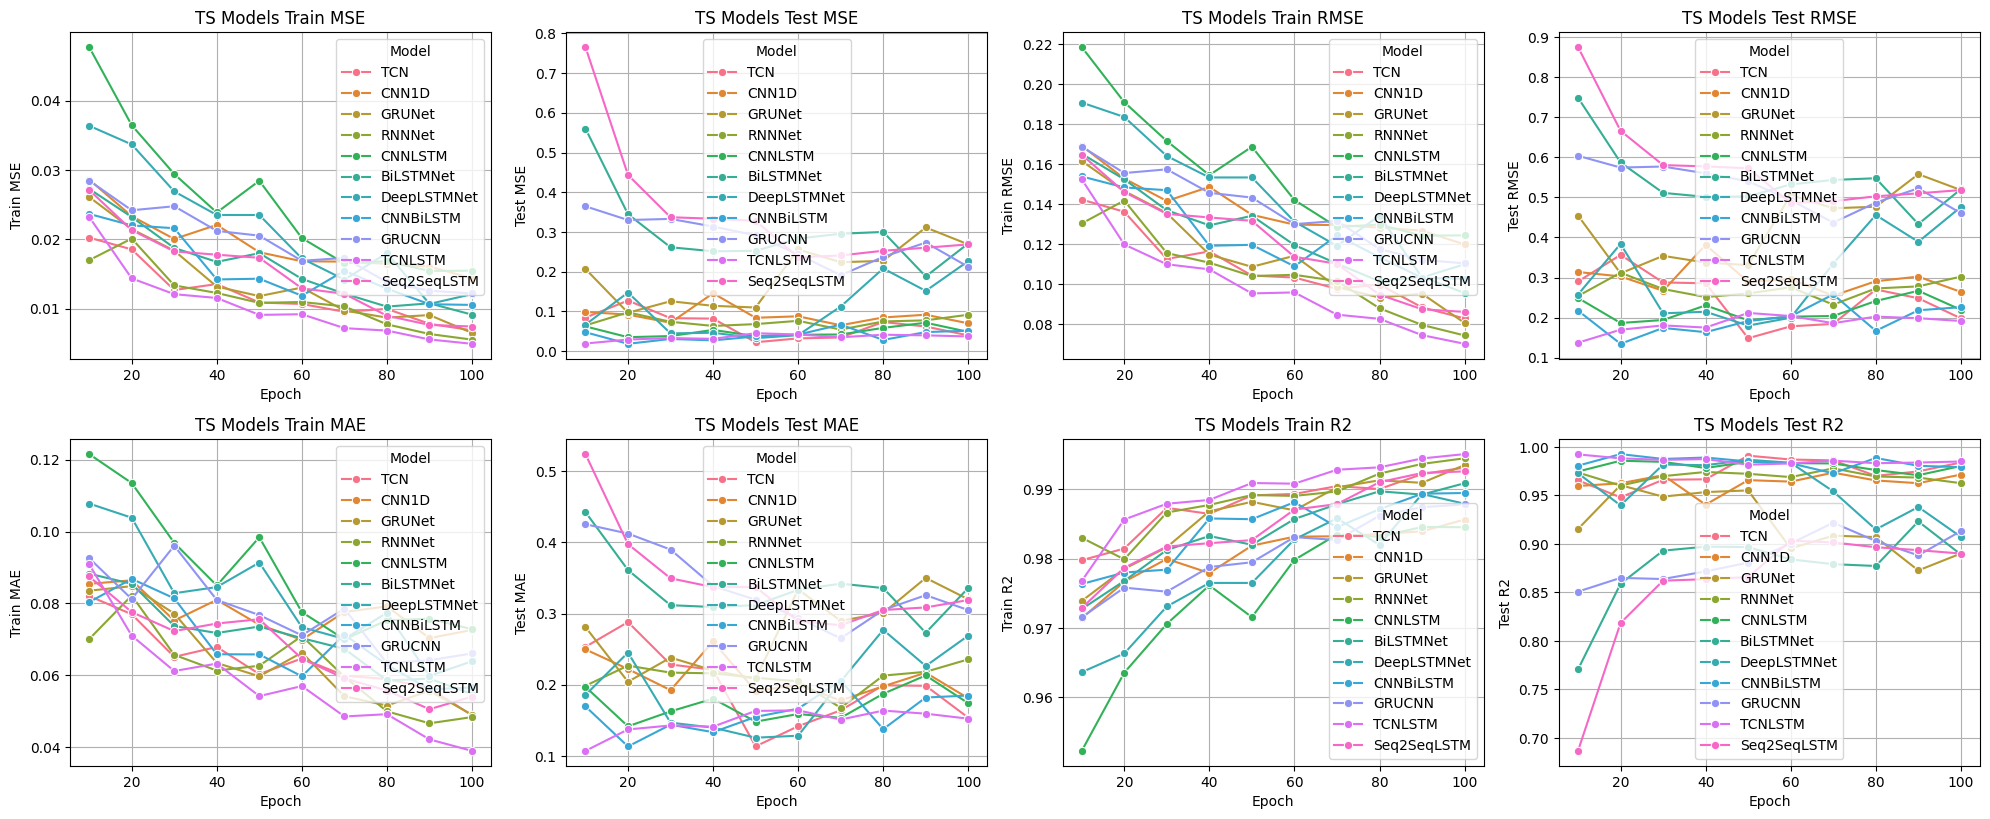

In [52]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("TS Models " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
fig = plt.gcf()
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

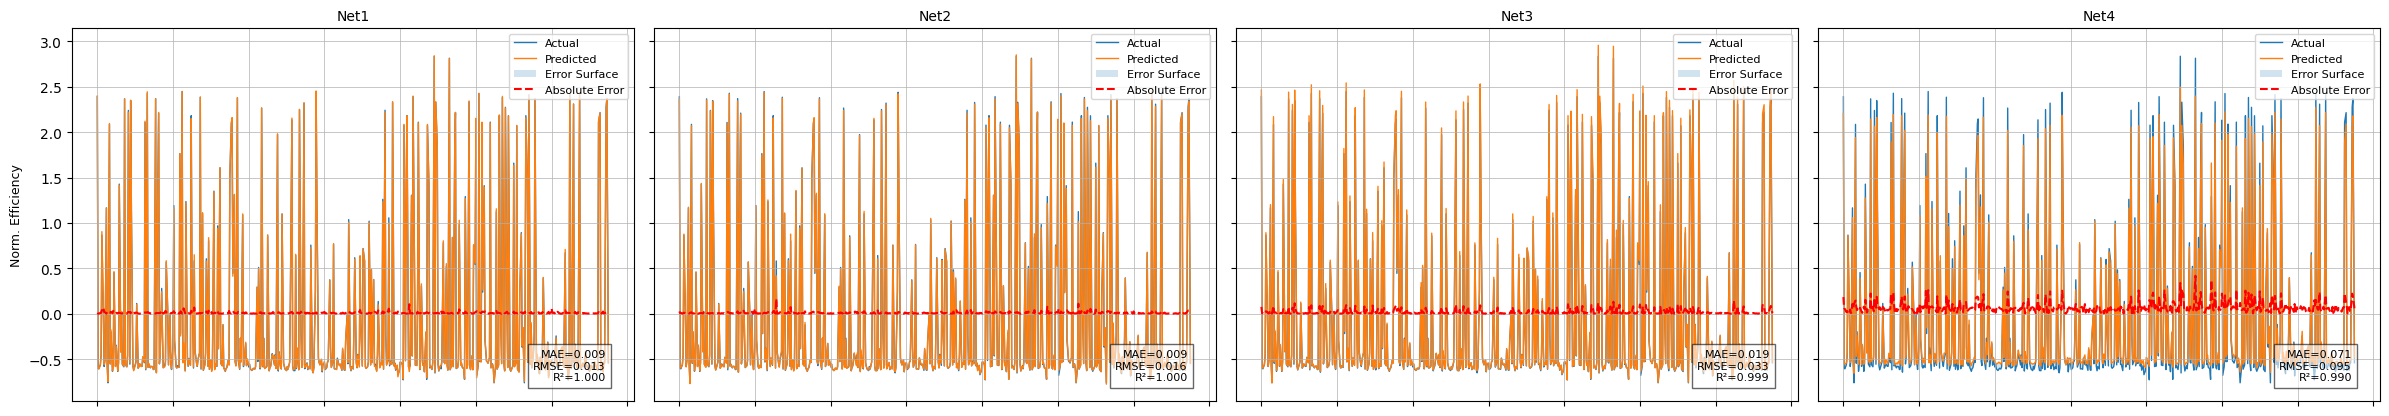

In [46]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

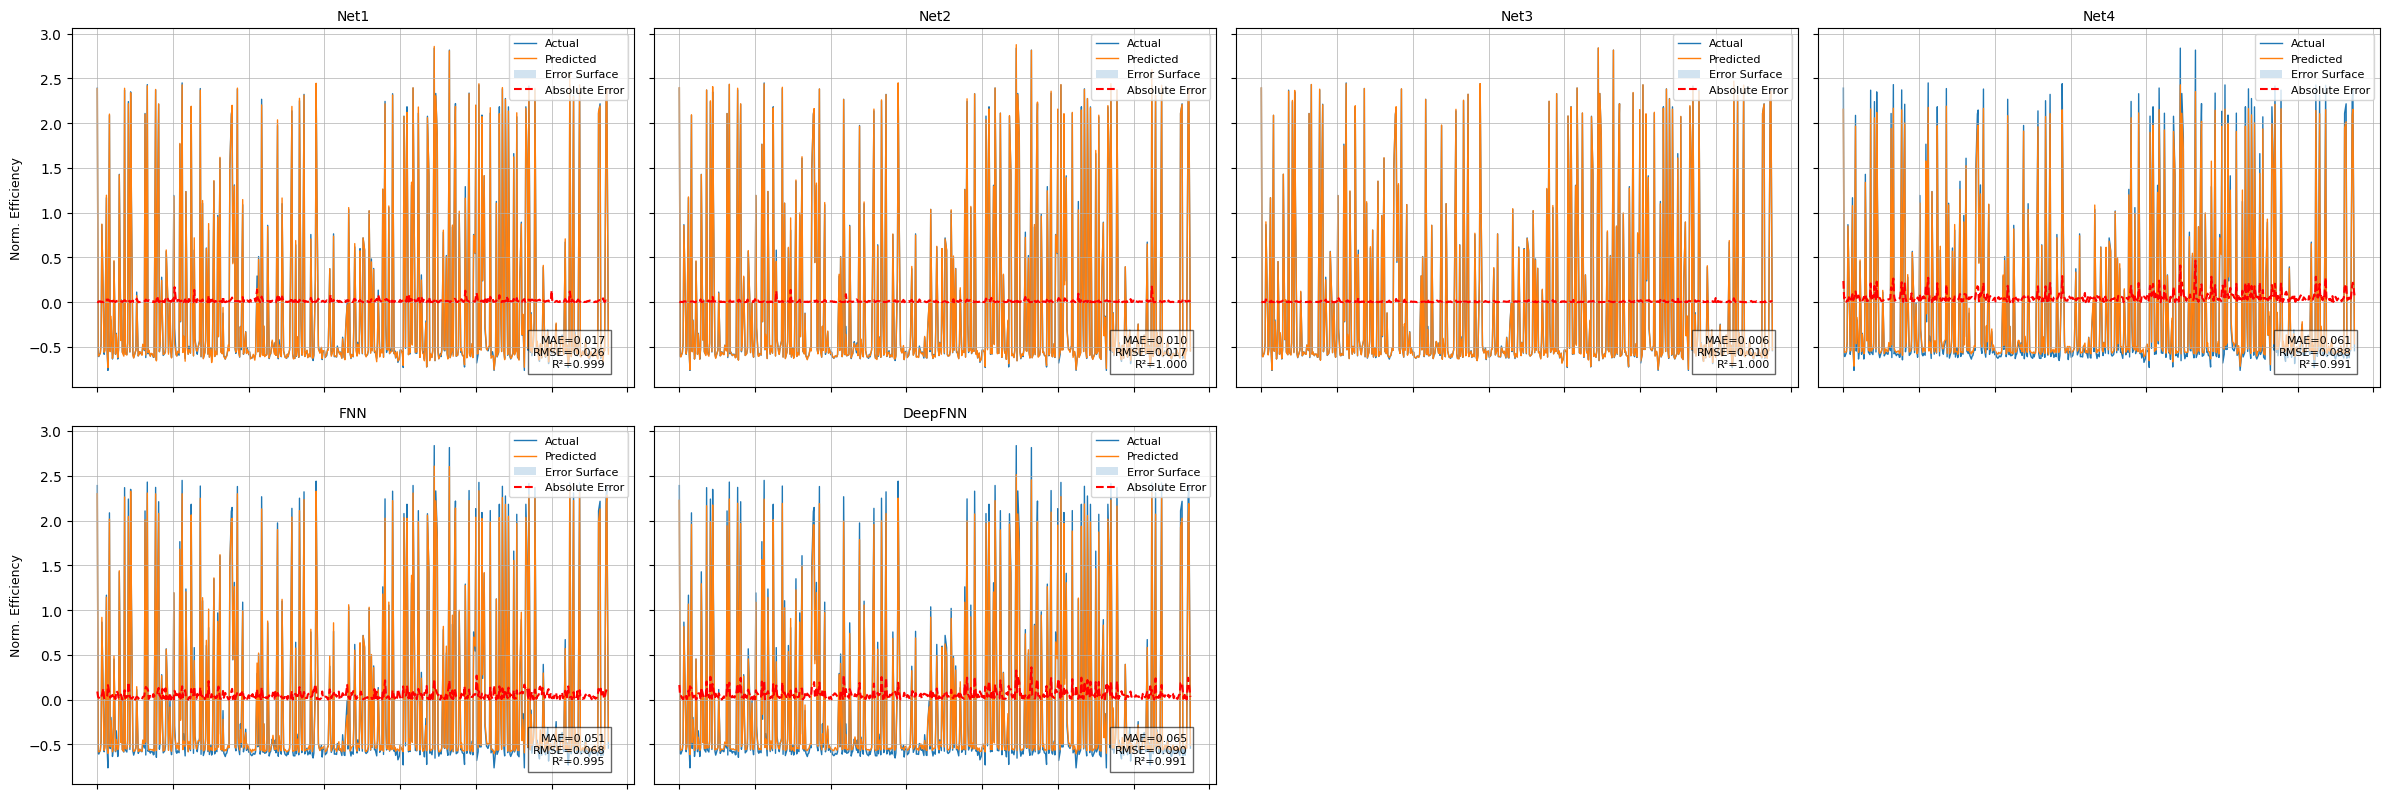

In [47]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets_tabular.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df_tabular
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

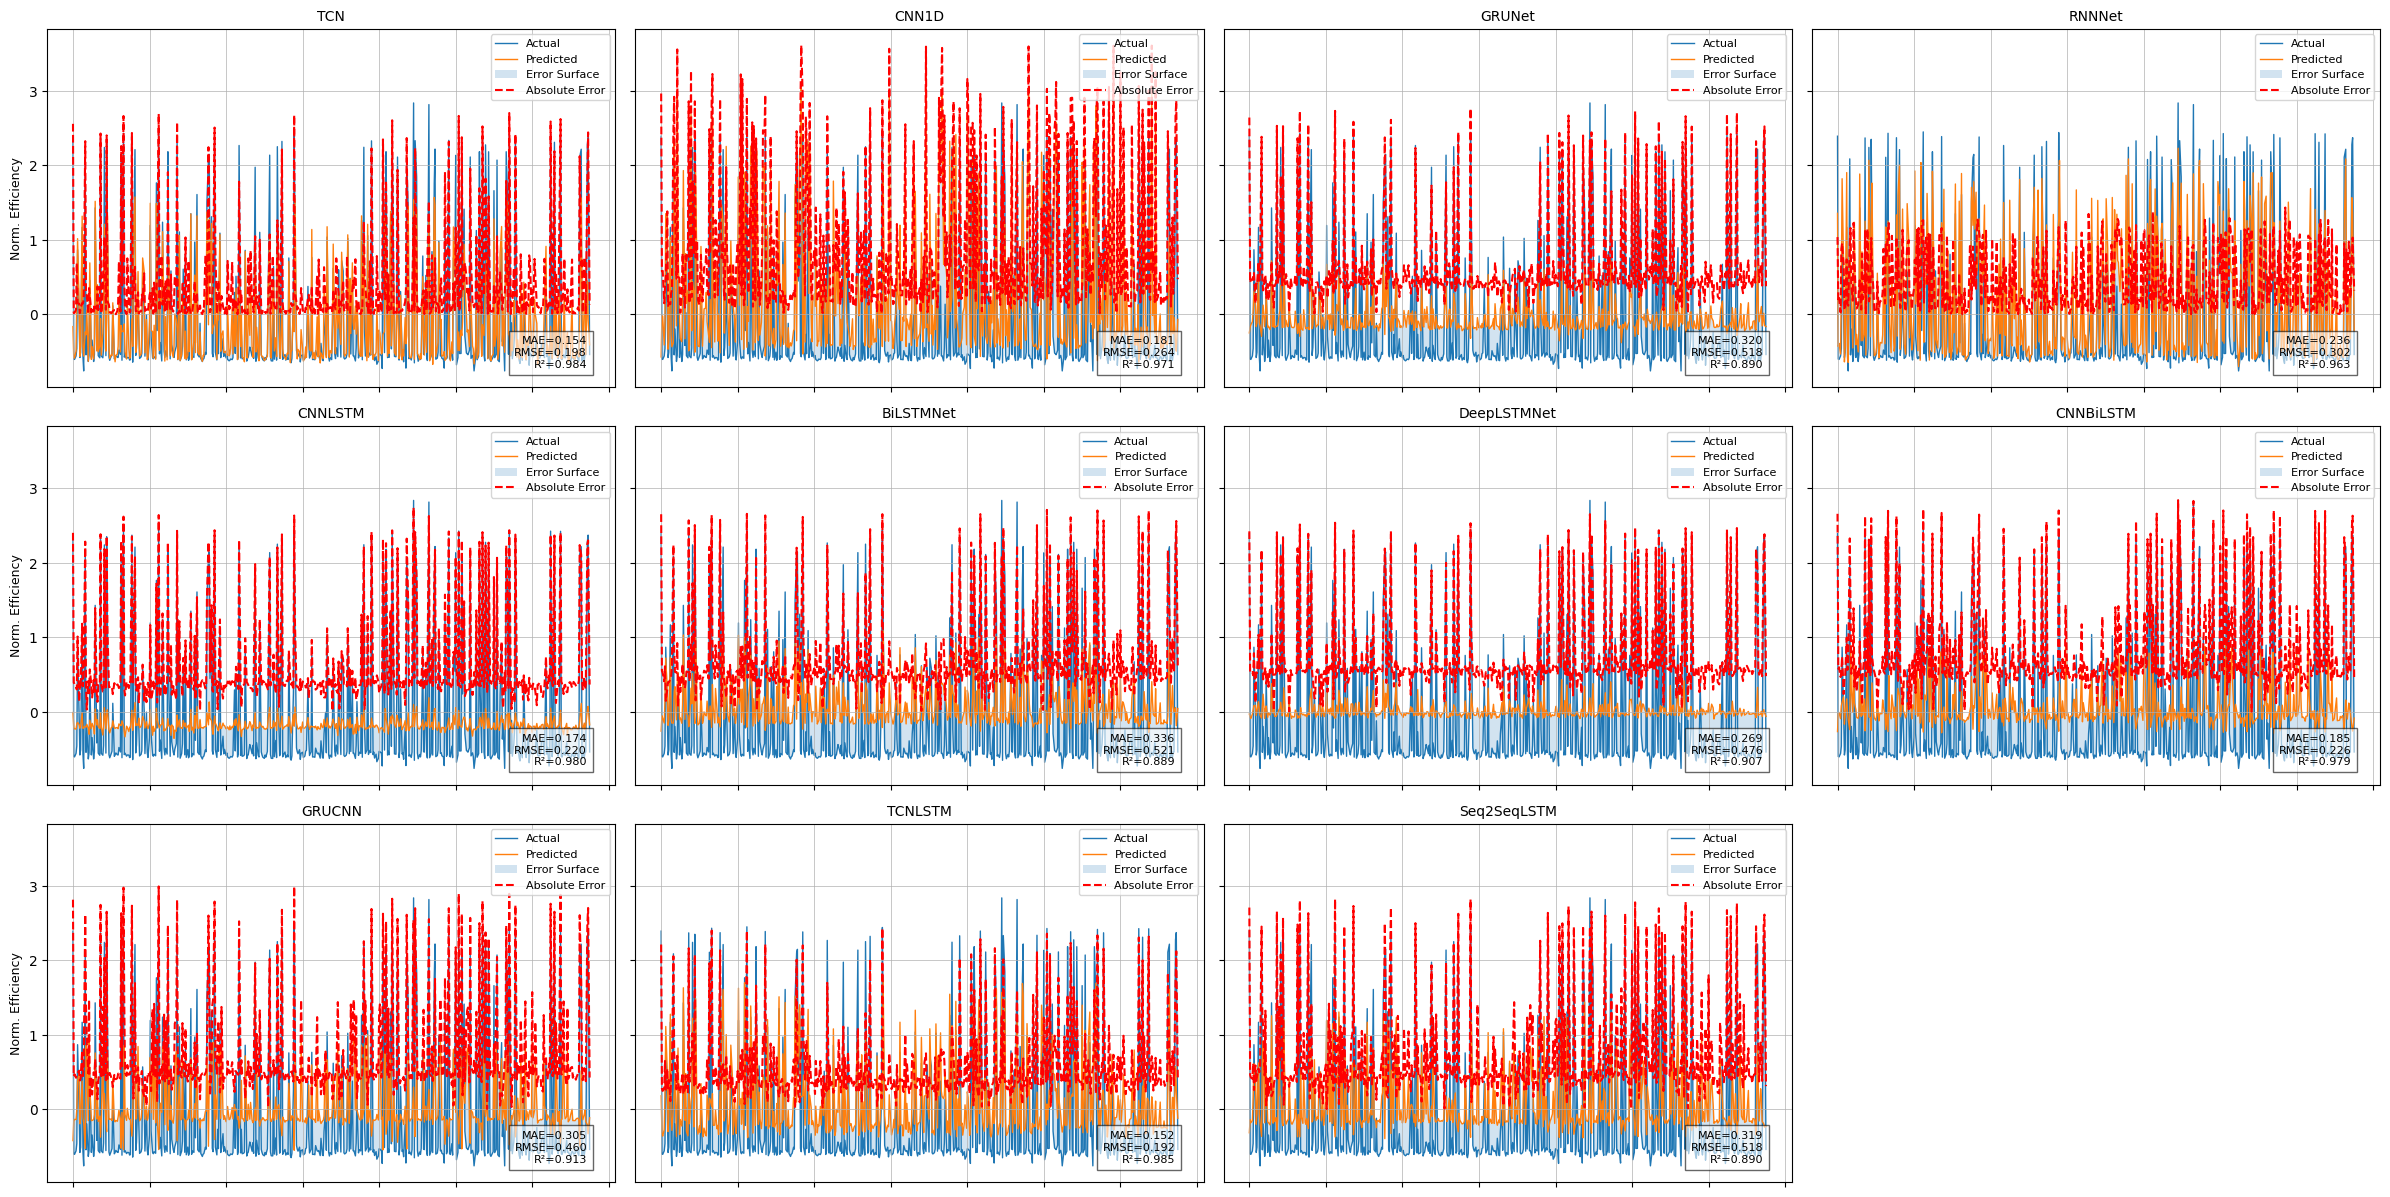

In [48]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_ts_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [56]:
for name, model in nets.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures["Train_Metrics_Nets"]},
        pred_figs={"Predictions": pred_figures_nets["Prediction_Nets"]},
        base_dir=Path("..")
    )

In [57]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs={"Train_Metrics": train_figures_tabular["Train_Metrics_Tabular"]},
        pred_figs={"Predictions": pred_figures_nets_tab["Prediction_Nets_Tab"]},
        base_dir=Path("..")
    )

In [55]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures_ts["Train_Metrics_TS"]},
        pred_figs={"Predictions": pred_figures_nets_ts["Prediction_Nets_TS"]},
        base_dir=Path("..")
    )